# ２次元の混合ガウス分布とEMアルゴリズム
千葉工業大学 三上泰史  

(c)2017 Taishi Mikami 

This software is released under the MIT License, see LICENSE

## 流れ
このソースコードは、K個の2次元ガウス分布を含む混合ガウス分布から生成されたデータを使い、EMアルゴリズムを実装したものです。(K:クラスタ数)
1. クラスタリング対象データを生成
2. K個の2次元ガウス分布のパラメータの初期設定
3. Eステップの実行:各クラスタへのデータの負担率の計算
4. Mステップの実行:Eステップで得た負担率を用いて、ガウス分布のパラメータを更新
5. 対数尤度を求める
6. 対数尤度が最大化するまで3から5を繰り返す

In [33]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import math

In [48]:
class Gauss_Model():
    def __init__(self):
        self.k = 3
        self.pai = []
        self.sample = []
        self.gauss = []
        self.ganma = []
        self.clus = ['r','g','b']
        self.first = 0
        self.finish_flag = 0
        self.prev_log_likelihood = 0.0
    
    # K個のデータ群を生成
    def dataset(self,mean,sigma,n):
        
        for i in range(self.k):
            self.pai.append(1/self.k)
            samplesB = np.random.multivariate_normal(mean[i],sigma[i],n[i]).T
            if(i>=1):
                samplesA = np.column_stack((samplesA,samplesB))
            else:
                samplesA = samplesB
        self.sample = samplesA
        plt.scatter(self.sample[0],self.sample[1],color='g',marker='+',alpha=0.8)
    
    # K個のガウス分布を生成
    def make_gauss_model(self,ave,sigma):
        self.gauss = []
        for i in range(self.k):
            self.gauss.append(multivariate_normal(mean=ave[i],cov=sigma[i]))
    
    # グラフの描画
    def plot_graph(self,gauss,ganma):
        plt.figure()
        
        # ガウス分布を等高線で描画
        x,y = np.meshgrid(np.linspace(min(self.sample[0]),max(self.sample[0]),1000),np.linspace(min(self.sample[1]),max(self.sample[1]),1000))
        pos = np.dstack((x,y))
        for i in range(self.k):
            z = gauss[i].pdf(pos)
            plt.contour(x, y, z,colors=self.clus[i],alpha=0.5)
            
        if self.first == 0:
            # 生成データの描画
            plt.scatter(self.sample[0],self.sample[1],color="g",marker='+',alpha=0.8)
        else:
            # 各データがどのガウス分布に属しているか色付けして描画
            for i in range(len(self.sample[0])):
                plt.scatter(self.sample[0][i],self.sample[1][i],color=[ganma[i][0],ganma[i][1],ganma[i][2]],marker='+',alpha=0.8)
        self.first = 1
    
    # Eステップ
    def e_step(self,pai,gauss):
        self.ganma = []
        # 各データの負担率を計算
        for i in range(len(self.sample[0])):
            sum_p = 0.0
            p=[]
            for j in range(self.k):
                sum_p += pai[j]*gauss[j].pdf([self.sample[0][i],self.sample[1][i]])
            for j in range(self.k):
                p.append(pai[j]*gauss[j].pdf([self.sample[0][i],self.sample[1][i]])/sum_p)
            self.ganma.append(p)
    
    # Mステップ
    def m_step(self,ganma):
        N = []
        self.g_mean = []
        self.g_sigma = []
        self.pai = []

        for i in range(self.k):
            sum_p = 0.0
            for j in range(len(self.sample[0])):
                sum_p += ganma[j][i]
            N.append(sum_p)
            
            # 分布の中心の更新
            sum_x = 0.0
            sum_y = 0.0
            for j in range(len(self.sample[0])):
                sum_x += ganma[j][i]*self.sample[0][j]
                sum_y += ganma[j][i]*self.sample[1][j]
            self.g_mean.append([sum_x/N[i],sum_y/N[i]])
            
            # 分布の共分散行列の更新
            sum_p = 0.0
            sigma = []
            sigma = [np.array([self.sample[0][j],self.sample[1][j]])-np.array([self.g_mean[i]]) for j in range(len(self.sample[0]))]
            self.g_sigma.append(sum([ganma[j][i]*sigma[j].T.dot(sigma[j])for j in range(len(self.sample[0]))])/N[i])
            
            # 混合係数の更新
            self.pai.append(N[i]/len(self.sample[0]))
    
    #対数尤度の計算
    def log_likelihood(self,pai,gauss):
        sum_l = 0.0
        for n in range(len(self.sample[0])):
            t = [pai[k]*gauss[k].pdf([self.sample[0][n],self.sample[1][n]]) for k in range(self.k)]
            sum_l += math.log1p(sum(t))
        
        after_log_likelihood = sum_l
        
        # 0.1%以上対数尤度が変化しなければ計算を終了させる
        if self.prev_log_likelihood/after_log_likelihood > 0.999:
            self.finish_flag = 1
        else:
            self.prev_log_likelihood = after_log_likelihood

## 初期設定

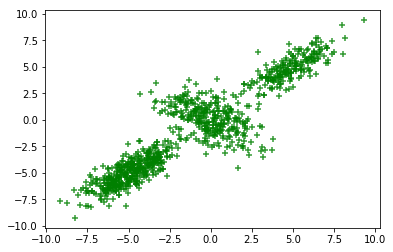

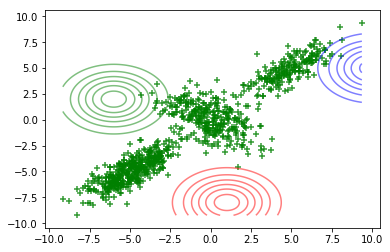

In [49]:
#パラメータの初期設定
gm = Gauss_Model()

#生成データ(平均ベクトル,共分散行列,データの個数)
s_mean = [[-5,-5],[0,0],[5,5]]
s_sigma = [[[1.9,1.5],[1.5,1.9]],
        [[2.1,-1.0],[-1.0,2.1]],
          [[1.9,1.5],[1.5,1.9]]]
n = [400,300,200]
gm.dataset(s_mean,s_sigma,n)

#ガウス分布(平均ベクトル,共分散行列)
g_mean = [[1,-8],[-6,2],[10,5]]
g_sigma = [[[3,0],[0,3]],
        [[3,0],[0,3]],
          [[3,0],[0,3]]]

gm.make_gauss_model(g_mean,g_sigma)
gm.plot_graph(gm.gauss,gm.ganma)

## EMアルゴリズムを実行

repeat: 14
Gauss0:
pai: 0.44372552328
mean: [-4.9080781092842276, -4.9309764202328603]
cov: [[ 1.86238013  1.47967755]
 [ 1.47967755  1.88894641]]


Gauss1:
pai: 0.332233047622
mean: [-0.066560092526554995, 0.087371771237616344]
cov: [[ 2.16018299 -1.09446717]
 [-1.09446717  2.13989577]]


Gauss2:
pai: 0.224041429098
mean: [4.8415456674966517, 4.8788694751270096]
cov: [[ 1.92924165  1.51305927]
 [ 1.51305927  1.8823743 ]]




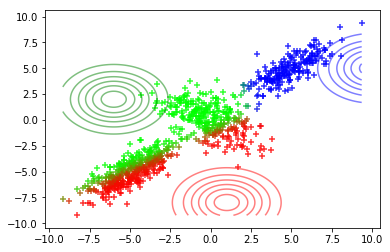

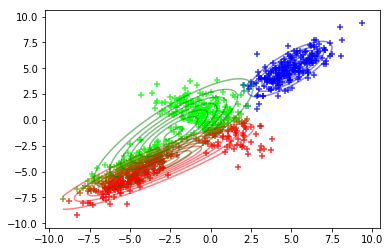

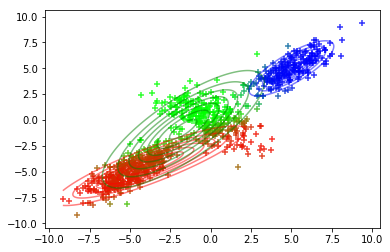

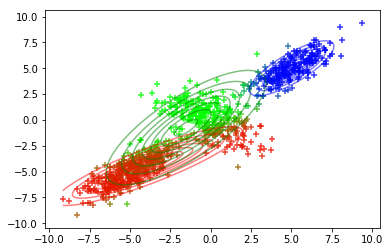

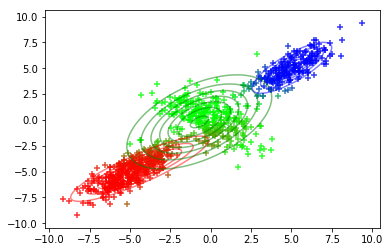

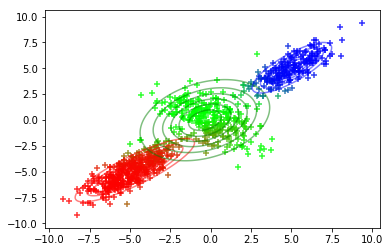

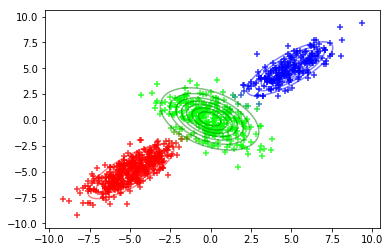

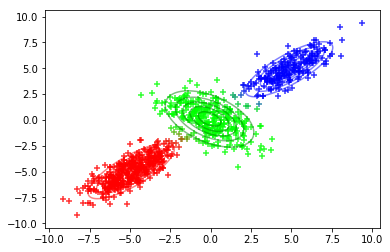

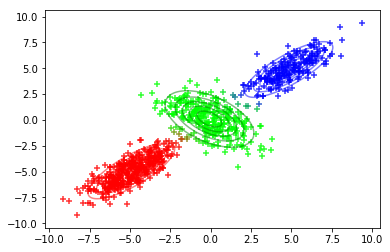

In [50]:
#4回ごとにグラフを描画
for i in range(99):
    gm.e_step(gm.pai,gm.gauss)
    if i % 4 == 0:
        gm.plot_graph(gm.gauss,gm.ganma)
    
    gm.m_step(gm.ganma)
    gm.make_gauss_model(gm.g_mean,gm.g_sigma)
    if i % 4 == 0:
        gm.plot_graph(gm.gauss,gm.ganma)
    gm.log_likelihood(gm.pai,gm.gauss)
    if gm.finish_flag == 1:
        break
gm.plot_graph(gm.gauss,gm.ganma)

# 収束時の各ガウス分布のパラメータ
print("repeat:",i+1)
for k in range(gm.k):
    print("Gauss{0}:".format(k))
    print("pai:",gm.pai[k])
    print("mean:",gm.g_mean[k])
    print("cov:",gm.g_sigma[k])
    print("\n")